In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

pd.options.display.max_columns = 100

c:\Users\acer\miniconda3\envs\jcop_usl\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Import Dataset

In [2]:
df = pd.read_csv("data/breast_cancer.csv")
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


## Cek Inbalance Target

In [3]:
df.target.value_counts(normalize=True)

1.0    0.627417
0.0    0.372583
Name: target, dtype: float64

# Cek Missing Value

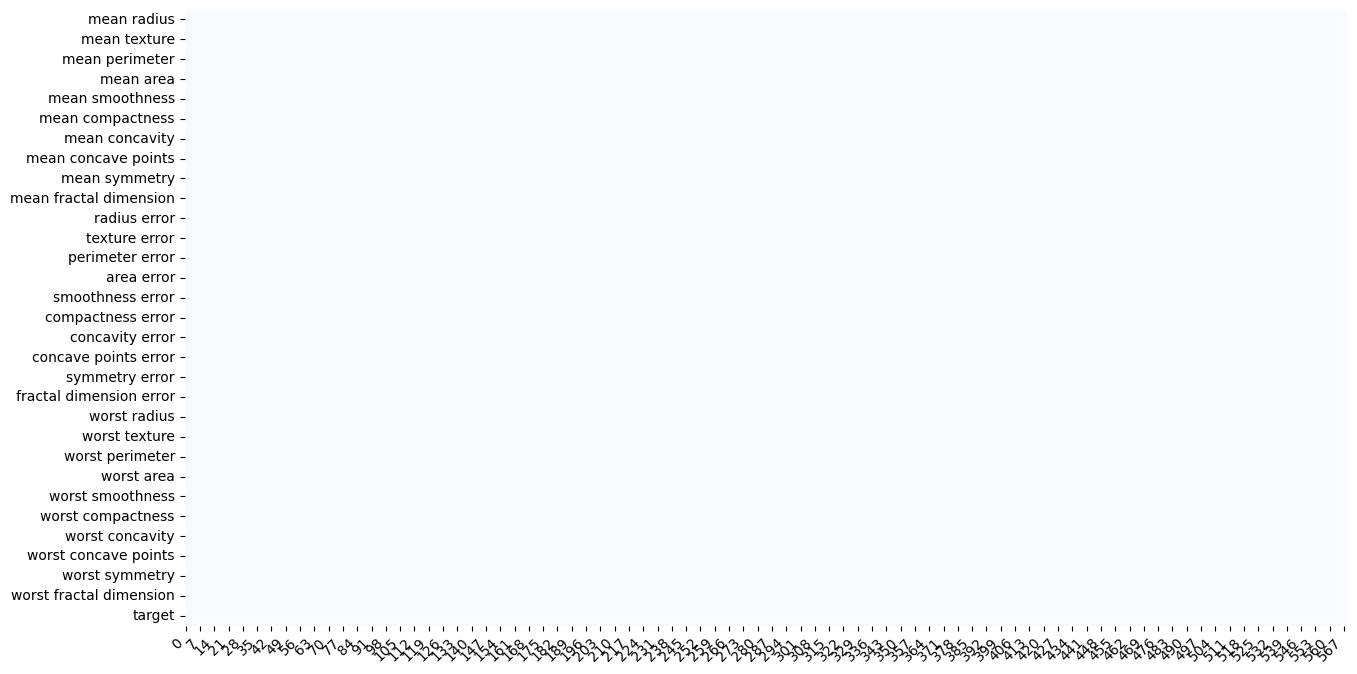

In [4]:
plot_missing_value(df)

# Dataset Splitting

In [5]:
X = df.drop(columns="target")
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

# Visualize PCA can help us

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

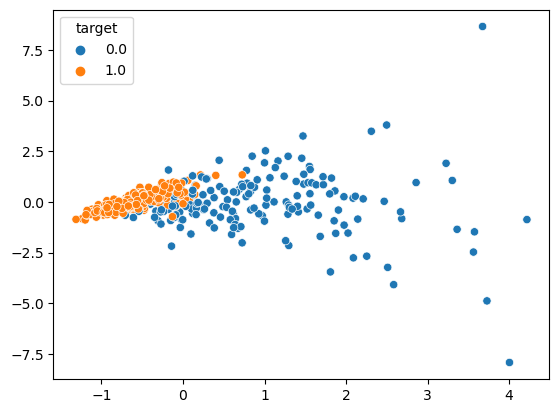

In [7]:
pca = PCA(n_components=2, whiten=True) # parameter Whiten adalah scaling yang ada di PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train)

# Training

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning.space import Integer, Real

In [9]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns)
    ])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('pca', PCA()),
    ('algo', SVC(max_iter=500))
])

parameter = {
    'algo__gamma': Real(low=-3, high=3, prior='log-uniform'),
    'algo__C': Real(low=-3, high=3, prior='log-uniform'),
    'pca__n_components': Integer(1, 30),
    'pca__whiten': [True, False],
}


model = RandomizedSearchCV(pipeline, parameter, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__C': 3.907967156822884, 'algo__gamma': 0.008632008168602547, 'pca__n_components': 19, 'pca__whiten': True}
0.9736263736263736 0.9582607180202162 0.9736842105263158


In [10]:
pipeline.get_params() # ini adalah code untuk cek parameter yang bisa di tuning

{'memory': None,
 'steps': [('prep', ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median'))]),
                                    Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
          'mean smoothness', 'mean compactness', 'mean concavity',
          'mean concave points', 'mean symmetry', 'mean fractal dimension',
          'radius error', 'texture error', 'perimeter error', 'area error',
          'smoothness error', 'compactness error', 'concavity error',
          'concave points error', 'symmetry error', 'fractal dimension error',
          'worst radius', 'worst texture', 'worst perimeter', 'worst area',
          'worst smoothness', 'worst compactness', 'worst concavity',
          'worst concave points', 'worst symmetry', 'worst fractal dimension'],
         dtype='object'))])),
  ('pca', PCA()),
  ('algo', SVC(max

# Bagaimana cara menentukan n_components dalam PCA -> Cumulative Explained Variance

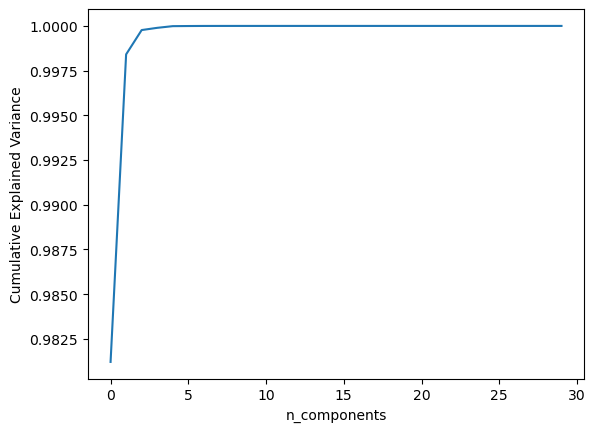

In [13]:
pca = PCA().fit(X_train)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel("n_components")
plt.ylabel("Cumulative Explained Variance");

- Dari hasil plot di atas dapat disimpulkan bahwa kalau kita menggunakan 5 n_components saja sudah bisa mencakup 100% informasi

# Implementasi PCA dengan 5 n_components

In [15]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns)
    ])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('pca', PCA(n_components=5, whiten=True)),
    ('algo', SVC(max_iter=500))
])


model = RandomizedSearchCV(pipeline, rsp.svm_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__C': 98.77700294007921, 'algo__gamma': 0.01879466824163846}
0.9692307692307692 0.9626612059951202 0.9649122807017544


- Hasil diatas menunjukan bahwa perbedaan dari kita mentuning <br> dan juga menentukan n_components 
dengan cara Cummulative Explained Variance hanya mengakibatkan perbedaan akurasi yang sangat kecil